# Mathematical Finance
In this section, we will go through some of the aspects of mathematical modeling in the field of finance
## 1. Bond pricing
### What is a bond?

### What do we need to price a risk-free bond?
Rate of interest ($r$), time to maturity/expiry ($t$), Principal/Notional ($N$), coupon rate ($c$)


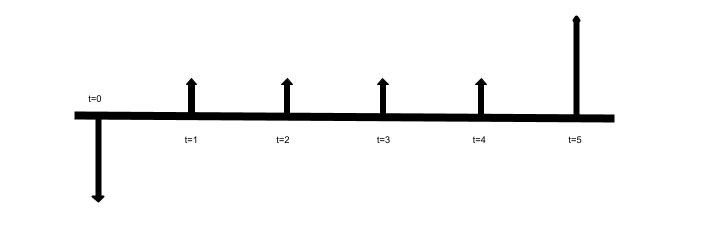

### Given this infoirmation, what is the fair price one should pay for this bond?


The value of the future cashflows as of today i.e. Time value of Money

$$P = \frac{c_1}{1+r_1} + \frac{c_2}{(1+r_2)^2} + \frac{c_3}{(1+r_3)^3} + ... + \frac{N+c_t}{(1+r_t)^t}$$

For simplicity, let's assume constant coupon rate ($c$) and rate of interest ($r$)

$$P = \frac{c}{1+r} + \frac{c}{(1+r)^2} + \frac{c}{(1+r)^3} + ... + \frac{N+c}{(1+r)^t}$$

In [2]:
import numpy as np

In [34]:
def create_cashflows(coupon, notional, time):
    cashflows      = [coupon]*time
    cashflows[-1] += notional
    return cashflows

def bond_pricer(coupon, notional, time, riskfree_rate):
    future_cashflows = create_cashflows(coupon, notional, time)
    bond_price       = 0.0
    for cashflow, tp in zip(future_cashflows, range(time)):
        bond_price += cashflow/(np.power((1+riskfree_rate), tp+1 ))
    return round(bond_price, 4)

In [35]:
c = 1    # coupon rate, absolute £ value
N = 100  # notional of the bond, £ value
t = 5    # time to maturity (in years)
r = 0.05 # risk-free rate of return (absolute), equivalent of 10%
print("Price of the bond is £", bond_pricer(c, N, t, r))

## sanity check
assert(bond_pricer(0, N, t, 0) == 100.0) # zero coupon- zero rate of interest
assert(bond_pricer(10, N, t, 0.1) == 100.0) # coupon rate == rate of interest

Price of the bond is £ 82.6821


### Pricing a risk bond
Now, most of bonds in the market are so-called risky or corporate bonds. There is a default risk associated with these bonds.
Let's assume at every discrete time interval, bonds can default with probability $d$. Incorporating this risk in the pricing, we have:
$$P = \Biggl( \frac{1-d}{1+r} \Biggr)c + \Biggl( \frac{1-d}{1+r} \Biggr)^2 c + \Biggl( \frac{1-d}{1+r} \Biggr)^3c + ... +  \Biggl( \frac{1-d}{1+r} \Biggr)^t(N+c)$$

In [36]:
def risky_bond_pricer(coupon, notional, time, riskfree_rate, default_probability = 0.0):
    future_cashflows = create_cashflows(coupon, notional, time)
    bond_price       = 0.0
    for cashflow, tp in zip(future_cashflows, range(time)):
        bond_price += cashflow*(np.power((1-default_probability), tp+1 ))/(np.power((1+riskfree_rate), tp+1 ))
    return round(bond_price, 4)

In [37]:
c = 10   # coupon rate, absolute £ value
N = 100  # notional of the bond, £ value
t = 5    # time to maturity (in years)
r = 0.05 # risk-free rate of return (absolute), equivalent of 10%
d = 0.1  # 10% default probability
print("Price of the bond is £", risky_bond_pricer(c, N, t, r, d))

## sanity check
assert(risky_bond_pricer(0, N, t, 0) == 100.0) # zero coupon- zero rate of interest
assert(risky_bond_pricer(10, N, t, 0.1) == 100.0) # coupon rate == rate of interest

Price of the bond is £ 78.5066


#### What if we allow the default probabilities to vary?

Instead of constant default probabilities, we can have time-varying default probabilities. Mathematically, this reduces to
$$P = \Biggl( \frac{1-d_1}{1+r} \Biggr)c + \Biggl( \frac{1-d_1}{1+r} \Biggr) \Biggl( \frac{1-d_2}{1+r} \Biggr)c + ... +  \Biggl( \frac{1-d_1}{1+r} \Biggr)....\Biggl( \frac{1-d_{t}}{1+r} \Biggr)(N+c)$$

So, if we have default probabilities, easy to work out risky bond price.

In [42]:
def risky_bond_pricer_time_varying_default_probs( coupon, notional, time, riskfree_rate, default_probabilities ):
    default_probabilities    = default_probabilities or [0.0]*time
    future_cashflows         = create_cashflows( coupon, notional, time )
    bond_price               = 0.0
    conditional_default_prob = 1
    for cashflow, tp in zip( future_cashflows, range( time ) ):
        conditional_default_prob = conditional_default_prob * ( 1 - default_probabilities[ tp ] )
        bond_price              += ( cashflow * conditional_default_prob / ( np.power( ( 1 + riskfree_rate ), tp + 1 ) ) )
    return round( bond_price, 4 )

In [45]:
c = 10                          # coupon rate, absolute £ value
N = 100                         # notional of the bond, £ value
t = 5                           # time to maturity (in years)
r = 0.05                        # risk-free rate of return (absolute), equivalent of 10%
d = [0.1, 0.1, 0.15, 0.2, 0.3]  # default probabilities
print("Price of the bond is £", risky_bond_pricer_time_varying_default_probs(c, N, t, r, d))

## sanity check
# Case-1 zero coupon- zero rate of interest- no default probability
assert(risky_bond_pricer_time_varying_default_probs(0, N, t, 0, None) == 100.0) 
# Case-2 coupon rate == rate of interest - no default probability
assert(risky_bond_pricer_time_varying_default_probs(10, N, t, 0.1, None) == 100.0) 
# Case-3 coupon rate == rate of interest - no default probability - both pricers should match
assert(risky_bond_pricer_time_varying_default_probs(10, N, t, 0.1, None) == risky_bond_pricer(10, N, t, 0.1))

Price of the bond is £ 59.6279


### default curve modeling
Usually, the problem we have at hand is we observe the bond prices in the market and we workout the (market expectation) of default probabilities.
Given the prices of bond written by the same entity but maturiting in 1 year, 2 year, ... t years could give us the picture what is the market expectation of entity's default.

In mathematical terms, we are given $P_1, P_2, ... , P_t $ and we are trying to work-out the dynamics of the default probabilities $d_1, d_2, ... , d_t$

$$
\begin{align*}
P_1 &= \Biggl( \frac{1-d_1}{1+r} \Biggr)(c + N) \\
\\
P_2 &= \Biggl( \frac{1-d_1}{1+r} \Biggr)c + \Biggl( \frac{1-d_1}{1+r} \Biggr) \Biggl( \frac{1-d_2}{1+r} \Biggr)(c + N) \\
\\
...\\
\\
P_t &= \Biggl( \frac{1-d_1}{1+r} \Biggr)c + \Biggl( \frac{1-d_1}{1+r} \Biggr) \Biggl( \frac{1-d_2}{1+r} \Biggr)c + ... +  \Biggl( \frac{1-d_1}{1+r} \Biggr)....\Biggl( \frac{1-d_{t}}{1+r} \Biggr)(c + N) \\
\end{align*}
$$

For the sake of simplicity, we can assume zero-coupon bonds:
$$
\begin{align*}
P_1 &= \Biggl( \frac{1-d_1}{1+r} \Biggr)N \\
\\
P_2 &= \Biggl( \frac{1-d_1}{1+r} \Biggr) \Biggl( \frac{1-d_2}{1+r} \Biggr)N \\
\\
...\\
\\
P_t &= \Biggl( \frac{1-d_1}{1+r} \Biggr)....\Biggl( \frac{1-d_{t}}{1+r} \Biggr)N \\
\end{align*}
$$

Working backwards, we can solve for $d_i$
